In [1]:
from mpi4py import MPI
from manapy.ast import Variable
from manapy.base.base import Struct
from manapy.ddm import Domain
from manapy.partitions import MeshPartition
from manapy.solvers.advec.tools_utils import initialisation_gaussian_2d
from manapy.solvers.ls import PETScKrylovSolver
import numpy as np
import time
from numba import cuda

import matplotlib.pyplot as plt

from timeit import default_timer as timer

###############
# test_time
###############

def test_time(iter, fun):
  #fun()
  start_time = timer()
  for _ in range(iter):
    fun()
  end_time = timer()
  elapsed_time = (end_time - start_time) / iter
  print(f"{elapsed_time * 1000:.5f} ms")
  #print(f"{elapsed_time * 1000000:.5f} micros")

###############
# init
###############
def init(dim, mesh_path):
  running_conf = Struct(backend="numba", signature=True, cache=True, precision="double")
  MeshPartition(mesh_path, dim=dim, conf=running_conf, periodic=[0,0,0])

  domain = Domain(dim=dim, conf=running_conf)
  faces = domain.faces
  cells = domain.cells
  halos = domain.halos
  nodes = domain.nodes

  nbnodes = domain.nbnodes
  nbfaces = domain.nbfaces
  nbcells = domain.nbcells
  backend = domain.backend
  signature = domain.signature

  test_para = 'test_2'

  if test_para == "test_1" :
      fi    = 0.81
      U_n  = 3.e-3
      Pin = 1e5
      perm0 = 6.83e-9
      mu0 = 0.3
      tfinal = 122

      test = "pression"
      filename = "Geom_exp3.msh"


  if test_para == "test_2" :
      C0 = 0.
      alpha0 = 1.
      sigma_u = 0.85
      a = 1.
      A = 0.68
      Pin = 3e5
      mu0  = 0.109
      fi0 =  0.45
      U_n  = 1e-1
      tfinal = 1000

      test = "pression"
      filename = "TMesh.msh"

  boundariesI = {"in" : "dirichlet",
                  "out" : "neumann",
                  "upper":"neumann",
                  "bottom":"neumann"
              }
  valuesI = {"in" : 1}

  I = Variable(domain=domain, BC=boundariesI, values=valuesI,  terms = ["Flux"])
  I.update_ghost_value()

  # Concentration
  boundariesC = {"in" : "dirichlet",
                  "out" : "neumann",
                  "upper":"neumann",
                  "bottom":"neumann"
              }
  valuesC = {"in" : C0}
  C = Variable(domain=domain, BC=boundariesC, values=valuesC,  terms = ["Flux"])
  C.update_ghost_value()

  fiC = Variable(domain=domain, terms = ["Flux"])

  perm_x_0  = Variable(domain=domain)
  perm_y_0  = Variable(domain=domain)

  perm_x  = Variable(domain=domain)
  perm_y  = Variable(domain=domain)

  visc  = Variable(domain=domain)
  fi  = Variable(domain=domain)
  sigma = Variable(domain=domain)
  alpha = Variable(domain=domain)

  ## initialization of viscosity, porosity and filtration coieficient
  visc.cell[:]  = mu0
  fi.cell[:]  = fi0
  alpha.cell[:] = alpha0
  visc.update_ghost_value()
  fi.update_ghost_value()
  alpha.update_ghost_value()

  ## initialization of the permeability
  for i in range(nbcells):
      if cells.center[i][1] >= 0.0014:
          perm_x_0.cell[i] =  4.e-11
          perm_y_0.cell[i] =  2.e-11

      else:
          perm_x_0.cell[i] =  2.e-11
          perm_y_0.cell[i] =  4.e-11

  # Perm changes over time
  perm_x.cell[:] = perm_x_0.cell[:]
  perm_y.cell[:] = perm_y_0.cell[:]

  perm_x.update_ghost_value()
  perm_y.update_ghost_value()

  ## injection mode
  if test == "pression":
      boundariesP = {"in" : "dirichlet",
                    "out" : "dirichlet",
                    "upper":"neumann",
                    "bottom":"neumann"
                  }
      valuesP = {"in" : Pin, "out": 0. }
      boundariesU = {"in" : "neumann",
                    "out" : "neumann",
                    "upper":"noslip",
                    "bottom":"noslip"}
      
      u  = Variable(domain=domain, BC=boundariesU)
      v  = Variable(domain=domain, BC=boundariesU)


  elif test == "debit":
      boundariesP = {"in" : "neumannNH",
                    "out" : "dirichlet",
                    "upper":"neumann",
                    "bottom":"neumann"
                  }
      cst = (mu0/perm0)*U_n
      valuesP = {"in" : cst, "out": 0. }

      boundariesU = {"in" : "dirichlet",
                    "out" : "neumann",
                    "upper":"neumann",
                    "bottom":"neumann"
                  }
      valuesU = {"in": U_n}
      u  = Variable(domain=domain)#, BC=boundariesU, values=valuesU)

  v  = Variable(domain=domain)
  w  = Variable(domain=domain)

  P = Variable(domain=domain, BC=boundariesP, values=valuesP)
  Pexact = Variable(domain=domain)
  Iexact = Variable(domain=domain)


  for i in domain.infaces:
      K = faces.cellid[i][0]
      I.cell[K] = 1.

  x0    = 0.
  cst = 0.
  time = 0
  miter = 0
  niter = 1
  saving_at_node = 1
  order = 2
  cfl = 0.8
  alpha_para = 2e-6

  dissip_I = np.zeros(nbcells)
  src_C = np.zeros(nbcells)
  src_I = np.zeros(nbcells)
  div = np.zeros(nbcells)

  conf = Struct(reuse_mtx=False, with_mtx=True, scheme='diamond', verbose=False, 
                precond='gamg', sub_precond="amg",
                eps_a=1e-10, eps_r=1e-10, method="gmres")
                
  L = PETScKrylovSolver(domain=domain, var=P, conf=conf)


  Errors = []
  Times = []
  x_front = []
  c = 1
  d_t = 1e-4

  return (domain, L, P, I, alpha_para, nbcells, visc, faces)

In [2]:
dim = 2
mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/manapy/mesh/2D/carre.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/manapy/mesh/2D/carre_hybrid.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/gpu_accelerator/functions/square_larger.msh"
#mesh_file = "/home/aben-ham/Desktop/work/stage/my_manapy/gpu_accelerator/functions/square.msh"
#mesh_file = "/home/ayoub.hamou/mesh/square.msh"
#mesh_file = "/home/ayoub.hamou/mesh/square_larger.msh"
domain, L, P, I, alpha_para, nbcells, visc, faces = init(dim=dim, mesh_path=mesh_file)

Reading gmsh file ...
Saving partition files ...
Number of Cells: 105826
Number of Vertices: 53314
Local domain contruction ...
SetUp the Linear system ...


In [56]:
from numba import cuda

def create_var(v):
  return (v, cuda.to_device(v))


host_cellfid, d_cellfid = create_var(domain.faces.cellid)
host_nodeidf, d_nodeidf = create_var(domain.faces.nodeid)
host_faceidc, d_faceidc = create_var(domain.cells.faceid)
host_vertexn, d_vertexn = create_var(domain.nodes.vertex)
host_halofid, d_halofid = create_var(domain.faces.halofid)
host_haloext, d_haloext = create_var(domain.halos.halosext)
host_oldnamen, d_oldnamen = create_var(domain.nodes.oldname)
host_volume, d_volume = create_var(domain.cells.volume)
host_cellnid, d_cellnid = create_var(domain.nodes.cellid)
host_centerc, d_centerc = create_var(domain.cells.center)
host_centerh, d_centerh = create_var(domain.halos.centvol)
host_halonid, d_halonid = create_var(domain.nodes.halonid)
host_periodicnid, d_periodicnid = create_var(domain.nodes.periodicid)
host_centergn, d_centergn = create_var(domain.nodes.ghostcenter)
host_halocentergn, d_halocentergn = create_var(domain.nodes.haloghostcenter)
host_airDiamond, d_airDiamond = create_var(domain.faces.airDiamond)
host_lambda_x, d_lambda_x = create_var(domain.nodes.lambda_x)
host_lambda_y, d_lambda_y = create_var(domain.nodes.lambda_y)
host_number, d_number = create_var(domain.nodes.number)
host_R_x, d_R_x = create_var(domain.nodes.R_x)
host_R_y, d_R_y = create_var(domain.nodes.R_y)
host_param1, d_param1 = create_var(faces.param1)
host_param2, d_param2 = create_var(faces.param2)
host_param3, d_param3 = create_var(faces.param3)
host_param4, d_param4 = create_var(faces.param4)
host_shift, d_shift = create_var(domain.cells.shift)
host_nbelements, d_nbelements = L.localsize, L.localsize
host_loctoglob, d_loctoglob = create_var(domain.cells.loctoglob)
host_BCdirichlet, d_BCdirichlet = create_var(P.BCdirichlet)
host_a_loc, d_a_loc = create_var(L._data)
host_irn_loc, d_irn_loc = create_var(L._row)
host_jcn_loc, d_jcn_loc = create_var(L._col)
host_matrixinnerfaces, d_matrixinnerfaces = create_var(L.matrixinnerfaces)
host_halofaces, d_halofaces = create_var(domain.halofaces)
host_dirichletfaces, d_dirichletfaces = create_var(P.dirichletfaces)
host_Icell, d_Icell = create_var(I.cell)
host_alpha_P, d_alpha_P = alpha_para, alpha_para
host_perm_vec, d_perm_vec = create_var(np.ones(nbcells))
host_visc_vec, d_visc_vec = create_var(visc.cell)
host_BCneumannNH, d_BCneumannNH = create_var(P.BCneumannNH)
host_dist, d_dist = create_var(faces.dist_ortho)






In [58]:
#The original function from functions2d.py

from numpy import  int32, float32, uint32
import numpy as np

def get_triplet_2d_with_contrib(cellfid:'int32[:,:]', nodeidf:'int32[:,:]', faceidc:'int32[:,:]', vertexn:'float[:,:]', halofid:'int32[:]',
                                haloext:'int32[:,:]', oldnamen:'uint32[:]', volume:'float[:]', 
                                cellnid:'int32[:,:]', centerc:'float[:,:]', centerh:'float[:,:]', halonid:'int32[:,:]', 
                                periodicnid:'int32[:,:]', 
                                centergn:'float[:,:,:]', halocentergn:'float[:,:,:]', airDiamond:'float[:]', 
                                lambda_x:'float[:]', lambda_y:'float[:]', number:'uint32[:]', R_x:'float[:]', 
                                R_y:'float[:]', param1:'float[:]', 
                                param2:'float[:]', param3:'float[:]', param4:'float[:]', shift:'float[:,:]', 
                                nbelements:'int32', loctoglob:'int32[:]',
                                BCdirichlet:'uint32[:]', a_loc:'float[:]', irn_loc:'int32[:]', jcn_loc:'int32[:]',
                                matrixinnerfaces:'uint32[:]', halofaces:'uint32[:]', dirichletfaces:'uint32[:]',
                                Icell:'float[:]', #Ihalo:'float[:]', Ihaloghost:'float[:]',
                                alpha_P:'float', perm_vec:'float[:]', 
                                visc_vec:'float[:]', BCneumannNH:'uint32[:]', dist:'float[:]'):
    
    def search_element(a:'int32[:]', target_value:'int32'):
        find = 0
        for val in a:
            if val == target_value:
                find = 1
                break
        return find
        
    center = np.zeros(2)
    parameters = np.zeros(2)
    cmpt = 0

    for i in matrixinnerfaces:
        nbfL = faceidc[cellfid[i][0]][-1]
        nbfR = faceidc[cellfid[i][1]][-1]
        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        parameters[0] = param4[i]; parameters[1] = param2[i]
    
        c_right = cellfid[i][1]
        c_rightglob = loctoglob[c_right]
        
        #perm_visc = dist[i][0]/(dist[i][1]/(perm_vec[c_rightglob]/visc_vec[c_rightglob]) + dist[i][2]/(perm_vec[c_leftglob]/visc_vec[c_leftglob]))

        # perm = dist[i][0]/(dist[i][1]/perm_vec[c_rightglob] + dist[i][2]/perm_vec[c_leftglob])
        # visc = dist[i][0]/(dist[i][1]/visc_vec[c_rightglob] + dist[i][2]/visc_vec[c_leftglob])

        perm = 0.5 * (perm_vec[c_rightglob] + perm_vec[c_leftglob])
        visc = 0.5 * (visc_vec[c_rightglob] + visc_vec[c_leftglob])

        perm_visc = perm / visc
        
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_leftglob
        value = param1[i] / volume[c_left]
        a_loc[cmpt] = value*Icell[c_left]*(perm_visc) + (1/nbfL)*volume[c_left]*alpha_P*(1 - Icell[c_left])
        cmpt = cmpt + 1
        
        cmptparam = 0
        for nod in nodeidf[i][:nodeidf[i][-1]]:
            if search_element(BCdirichlet, oldnamen[nod]) == 0:# and search_element(BCneumannNH, oldnamen[nod]) == 0:
                for j in range(cellnid[nod][-1]):
                    center[:] = centerc[cellnid[nod][j]][0:2]
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                              lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    irn_loc[cmpt] = c_leftglob
                    jcn_loc[cmpt] = loctoglob[cellnid[nod][j]]
                    a_loc[cmpt] = value*Icell[c_left]*(perm_visc) 
                    cmpt = cmpt + 1
                    #right cell-----------------------------------                                                                                              
                    value =  -1. * alpha / volume[c_right] * parameters[cmptparam]
                    irn_loc[cmpt] = c_rightglob
                    jcn_loc[cmpt] = loctoglob[cellnid[nod][j]]
                    a_loc[cmpt] = value*Icell[c_right]*(perm_visc) 
                    cmpt = cmpt + 1
                
                for j in range(len(centergn[nod])):
                    if centergn[nod][j][-1] != -1:
                        center[:] = centergn[nod][j][0:2]
                        xdiff = center[0] - vertexn[nod][0]
                        ydiff = center[1] - vertexn[nod][1]
                        alpha = (1. + lambda_x[nod]*xdiff + \
                                  lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                        index = int(centergn[nod][j][2])
                        value = alpha / volume[c_left] * parameters[cmptparam]
                        irn_loc[cmpt] = c_leftglob
                        jcn_loc[cmpt] = loctoglob[index]
                        a_loc[cmpt] = value*Icell[c_left]*(perm_visc) 
                        cmpt = cmpt + 1
                        #right cell-----------------------------------                                                                                              
                        value = -1. * alpha / volume[c_right] * parameters[cmptparam]
                        irn_loc[cmpt] = c_rightglob
                        jcn_loc[cmpt] = loctoglob[index]
                        a_loc[cmpt] = value*Icell[c_right]*(perm_visc) 
                        cmpt = cmpt + 1
                        
                for j in range(len(halocentergn[nod])):
                    if halocentergn[nod][j][-1] != -1:
                        center[:] = halocentergn[nod][j][0:2]
                        xdiff = center[0] - vertexn[nod][0]
                        ydiff = center[1] - vertexn[nod][1]
                        alpha = (1. + lambda_x[nod]*xdiff + \
                                  lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                        index = int(halocentergn[nod][j][2])
#                        cell  = int(halocentergn[nod][j][-1])
                        value = alpha / volume[c_left] * parameters[cmptparam]
                        irn_loc[cmpt] = c_leftglob
                        jcn_loc[cmpt] = haloext[index][0]
                        a_loc[cmpt] = value*Icell[c_left]*(perm_visc) 
                        cmpt = cmpt + 1
                        #right cell-----------------------------------                                                                                              
                        value = -1. * alpha / volume[c_right] * parameters[cmptparam]
                        irn_loc[cmpt] = c_rightglob
                        jcn_loc[cmpt] = haloext[index][0]
                        #TODO 
                        a_loc[cmpt] = value*Icell[c_right]*(perm_visc)#value*Ihaloghost[int(halocentergn[nod][j][-1])]*(perm/visc)   
                        cmpt = cmpt + 1
                              
                for j in range(halonid[nod][-1]):
                    center[:] = centerh[halonid[nod][j]][0:2]
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                              lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    irn_loc[cmpt] = c_leftglob
                    jcn_loc[cmpt] = haloext[halonid[nod][j]][0]
                    a_loc[cmpt] = value*Icell[c_left]*(perm_visc) 
                    cmpt = cmpt + 1
                    #right cell-----------------------------------                                                                                              
                    value =  -1. * alpha / volume[c_right] * parameters[cmptparam]
                    irn_loc[cmpt] = c_rightglob
                    jcn_loc[cmpt] = haloext[halonid[nod][j]][0]
                    a_loc[cmpt] = value*Icell[c_right]*(perm_visc)#value*Ihalo[halonid[nod][j]]*(perm/visc) 
                    cmpt = cmpt + 1
            cmptparam =+1
        
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_rightglob
        value =  param3[i] / volume[c_left]
        a_loc[cmpt] = value*Icell[c_left]*(perm_visc) 
        cmpt = cmpt + 1

        # right cell------------------------------------------------------
        irn_loc[cmpt] = c_rightglob
        jcn_loc[cmpt] = c_leftglob
        value =  -1. * param1[i] / volume[c_right]
        a_loc[cmpt] = value*Icell[c_right]*(perm_visc)
        cmpt = cmpt + 1
    
        irn_loc[cmpt] = c_rightglob
        jcn_loc[cmpt] = c_rightglob
        value =  -1. * param3[i] / volume[c_right]
        a_loc[cmpt] = value*Icell[c_right]*(perm_visc) + (1/nbfR)*volume[c_right]*alpha_P*(1 - Icell[c_right])
        cmpt = cmpt + 1
    '''
    for i in halofaces:
        nbfL = faceidc[cellfid[i][0]][-1]
        
        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        perm = perm_vec[c_leftglob] 
        visc = visc_vec[c_leftglob]

        parameters[0] = param4[i]; parameters[1] = param2[i]
        
        c_rightglob = haloext[halofid[i]][0]
        c_right     = halofid[i]
        
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_leftglob
        value =  param1[i] / volume[c_left]
        a_loc[cmpt] = value*Icell[c_left]*(perm/visc) + (1/nbfL)*volume[c_left]*alpha_P*(1 - Icell[c_left])
        cmpt = cmpt + 1

        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_rightglob
        value =  param3[i] / volume[c_left]
        a_loc[cmpt] = value*Icell[c_left]*(perm/visc)
        cmpt = cmpt + 1
        
        cmptparam = 0
        for nod in nodeidf[i]:
            if search_element(BCdirichlet, oldnamen[nod]) == 0 and search_element(BCneumannNH, oldnamen[nod]) == 0: 
                for j in range(cellnid[nod][-1]):
                    center[:] = centerc[cellnid[nod][j]][0:2]
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                              lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    irn_loc[cmpt] = c_leftglob
                    jcn_loc[cmpt] = loctoglob[cellnid[nod][j]]
                    a_loc[cmpt] = value*Icell[c_left]*(perm/visc)
                    cmpt = cmpt + 1
                    
                for j in range(len(centergn[nod])):
                    if centergn[nod][j][-1] != -1:
                        center[:] = centergn[nod][j][0:2]
                        xdiff = center[0] - vertexn[nod][0]
                        ydiff = center[1] - vertexn[nod][1]
                        alpha = (1. + lambda_x[nod]*xdiff + \
                                  lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                        index = int(centergn[nod][j][2])
                        value = alpha / volume[c_left] * parameters[cmptparam]
                        irn_loc[cmpt] = c_leftglob
                        jcn_loc[cmpt] = loctoglob[index]
                        a_loc[cmpt] = value*Icell[c_left]*(perm/visc)
                        cmpt = cmpt + 1
                        
                for j in range(len(halocentergn[nod])):
                    if halocentergn[nod][j][-1] != -1:
                        center[:] = halocentergn[nod][j][0:2]
                        xdiff = center[0] - vertexn[nod][0]
                        ydiff = center[1] - vertexn[nod][1]
                        alpha = (1. + lambda_x[nod]*xdiff + \
                                  lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                        index = int(halocentergn[nod][j][2])
                        value = alpha / volume[c_left] * parameters[cmptparam]
                        irn_loc[cmpt] = c_leftglob
                        jcn_loc[cmpt] = haloext[index][0]
                        a_loc[cmpt] = value*Icell[c_left]*(perm/visc)
                        cmpt = cmpt + 1

                for j in range(halonid[nod][-1]):
                    center[:] = centerh[halonid[nod][j]][0:2]
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                              lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    irn_loc[cmpt] = c_leftglob
                    jcn_loc[cmpt] = haloext[halonid[nod][j]][0]
                    a_loc[cmpt] = value*Icell[c_left]*(perm/visc)
                    cmpt = cmpt + 1
            cmptparam +=1
    '''
    for i in dirichletfaces:
        nbfL = faceidc[cellfid[i][0]][-1]
        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        perm = perm_vec[c_leftglob]
        visc = visc_vec[c_leftglob]

        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_leftglob
        value = param1[i] / volume[c_left]
        a_loc[cmpt] = value*Icell[c_left]*(perm/visc) + (1/nbfL)*volume[c_left]*alpha_P*(1 - Icell[c_left])
        cmpt = cmpt + 1
        
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_leftglob
        value = -1. * param3[i] / volume[c_left]
        a_loc[cmpt] = value*Icell[c_left]*(perm/visc) + (1/nbfL)*volume[c_left]*alpha_P*(1 - Icell[c_left])
        cmpt = cmpt + 1
 


In [59]:
#? using numba jit -> backend.py
#! Using parallel=True yields poor results.
import numba

numba_get_triplet_2d_with_contrib = numba.jit(get_triplet_2d_with_contrib, nopython=True, fastmath=True, parallel=False, cache=True)
def cpu_get_triplet_2d_with_contrib():
  return numba_get_triplet_2d_with_contrib(
    host_cellfid,
    host_nodeidf,
    host_faceidc,
    host_vertexn,
    host_halofid,
    host_haloext,
    host_oldnamen,
    host_volume,
    host_cellnid,
    host_centerc,
    host_centerh,
    host_halonid,
    host_periodicnid,
    host_centergn,
    host_halocentergn,
    host_airDiamond,
    host_lambda_x,
    host_lambda_y,
    host_number,
    host_R_x,
    host_R_y,
    host_param1,
    host_param2,
    host_param3,
    host_param4,
    host_shift,
    host_nbelements,
    host_loctoglob,
    host_BCdirichlet,
    host_a_loc,
    host_irn_loc,
    host_jcn_loc,
    host_matrixinnerfaces,
    host_halofaces,
    host_dirichletfaces,
    host_Icell,
    host_alpha_P,
    host_perm_vec,
    host_visc_vec,
    host_BCneumannNH,
    host_dist,
  )


In [60]:
#time taken by cpu_get_triplet_2d_with_contrib


cpu_get_triplet_2d_with_contrib()
test_time(70, cpu_get_triplet_2d_with_contrib)

134.03772 ms


In [66]:
@cuda.jit(device=True)
def search_element(a:'int32[:]', target_value:'int32'):
    for i in range(a.shape[0]):
        if a[i] == target_value:
            return 1
    return 0

@cuda.jit()
def kernel_get_triplet_2d_with_contrib(cellfid:'int32[:,:]', nodeidf:'int32[:,:]', faceidc:'int32[:,:]', vertexn:'float[:,:]', halofid:'int32[:]',
                                haloext:'int32[:,:]', oldnamen:'uint32[:]', volume:'float[:]', 
                                cellnid:'int32[:,:]', centerc:'float[:,:]', centerh:'float[:,:]', halonid:'int32[:,:]', 
                                periodicnid:'int32[:,:]', 
                                centergn:'float[:,:,:]', halocentergn:'float[:,:,:]', airDiamond:'float[:]', 
                                lambda_x:'float[:]', lambda_y:'float[:]', number:'uint32[:]', R_x:'float[:]', 
                                R_y:'float[:]', param1:'float[:]', 
                                param2:'float[:]', param3:'float[:]', param4:'float[:]', shift:'float[:,:]', 
                                nbelements:'int32', loctoglob:'int32[:]',
                                BCdirichlet:'uint32[:]', a_loc:'float[:]', irn_loc:'int32[:]', jcn_loc:'int32[:]',
                                matrixinnerfaces:'uint32[:]', halofaces:'uint32[:]', dirichletfaces:'uint32[:]',
                                Icell:'float[:]',
                                alpha_P:'float', perm_vec:'float[:]', 
                                visc_vec:'float[:]', BCneumannNH:'uint32[:]', dist:'float[:]', s_cmpt):
    

    idx = cuda.grid(1)

    parameters = cuda.local.array(2, param4.dtype)

    
    if idx < matrixinnerfaces.shape[0]:
        i = matrixinnerfaces[idx]

        nbfL = faceidc[cellfid[i][0]][-1]
        nbfR = faceidc[cellfid[i][1]][-1]
        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        parameters[0] = param4[i]
        parameters[1] = param2[i]
    
        c_right = cellfid[i][1]
        c_rightglob = loctoglob[c_right]
        

        perm = 0.5 * (perm_vec[c_rightglob] + perm_vec[c_leftglob])
        visc = 0.5 * (visc_vec[c_rightglob] + visc_vec[c_leftglob])

        perm_visc = perm / visc
        
        cmpt = cuda.atomic.add(s_cmpt, 0, 1)
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_leftglob
        value = param1[i] / volume[c_left]
        a_loc[cmpt] = value*Icell[c_left]*(perm_visc) + (1/nbfL)*volume[c_left]*alpha_P*(1 - Icell[c_left])
        
        
        cmptparam = 0
        for nod in nodeidf[i][:nodeidf[i][-1]]:
            if search_element(BCdirichlet, oldnamen[nod]) == 0:# and search_element(BCneumannNH, oldnamen[nod]) == 0:
                for j in range(cellnid[nod][-1]):
                    center = centerc[cellnid[nod][j]][0:2]
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                              lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    cmpt = cuda.atomic.add(s_cmpt, 0, 1)
                    irn_loc[cmpt] = c_leftglob
                    jcn_loc[cmpt] = loctoglob[cellnid[nod][j]]
                    a_loc[cmpt] = value*Icell[c_left]*(perm_visc) 
                    #right cell-----------------------------------                                                                                              
                    value =  -1. * alpha / volume[c_right] * parameters[cmptparam]
                    cmpt = cuda.atomic.add(s_cmpt, 0, 1)
                    irn_loc[cmpt] = c_rightglob
                    jcn_loc[cmpt] = loctoglob[cellnid[nod][j]]
                    a_loc[cmpt] = value*Icell[c_right]*(perm_visc) 
                
                for j in range(len(centergn[nod])):
                    if centergn[nod][j][-1] != -1:
                        center = centergn[nod][j][0:2]
                        xdiff = center[0] - vertexn[nod][0]
                        ydiff = center[1] - vertexn[nod][1]
                        alpha = (1. + lambda_x[nod]*xdiff + \
                                  lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                        index = int(centergn[nod][j][2])
                        value = alpha / volume[c_left] * parameters[cmptparam]
                        cmpt = cuda.atomic.add(s_cmpt, 0, 1)
                        irn_loc[cmpt] = c_leftglob
                        jcn_loc[cmpt] = loctoglob[index]
                        a_loc[cmpt] = value*Icell[c_left]*(perm_visc) 
                        #right cell-----------------------------------                                                                                              
                        value = -1. * alpha / volume[c_right] * parameters[cmptparam]
                        cmpt = cuda.atomic.add(s_cmpt, 0, 1)
                        irn_loc[cmpt] = c_rightglob
                        jcn_loc[cmpt] = loctoglob[index]
                        a_loc[cmpt] = value*Icell[c_right]*(perm_visc) 
                        
                for j in range(len(halocentergn[nod])):
                    if halocentergn[nod][j][-1] != -1:
                        center = halocentergn[nod][j][0:2]
                        xdiff = center[0] - vertexn[nod][0]
                        ydiff = center[1] - vertexn[nod][1]
                        alpha = (1. + lambda_x[nod]*xdiff + \
                                  lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                        index = int(halocentergn[nod][j][2])
#                        cell  = int(halocentergn[nod][j][-1])
                        value = alpha / volume[c_left] * parameters[cmptparam]
                        cmpt = cuda.atomic.add(s_cmpt, 0, 1)
                        irn_loc[cmpt] = c_leftglob
                        jcn_loc[cmpt] = haloext[index][0]
                        a_loc[cmpt] = value*Icell[c_left]*(perm_visc) 
                        #right cell-----------------------------------                                                                                              
                        value = -1. * alpha / volume[c_right] * parameters[cmptparam]
                        cmpt = cuda.atomic.add(s_cmpt, 0, 1)
                        irn_loc[cmpt] = c_rightglob
                        jcn_loc[cmpt] = haloext[index][0]
                        #TODO 
                        a_loc[cmpt] = value*Icell[c_right]*(perm_visc)#value*Ihaloghost[int(halocentergn[nod][j][-1])]*(perm/visc)   
                              
                for j in range(halonid[nod][-1]):
                    center = centerh[halonid[nod][j]][0:2]
                    xdiff = center[0] - vertexn[nod][0]
                    ydiff = center[1] - vertexn[nod][1]
                    alpha = (1. + lambda_x[nod]*xdiff + \
                              lambda_y[nod]*ydiff)/(number[nod] + lambda_x[nod]*R_x[nod] + lambda_y[nod]*R_y[nod])
                    value =  alpha / volume[c_left] * parameters[cmptparam]
                    cmpt = cuda.atomic.add(s_cmpt, 0, 1)
                    irn_loc[cmpt] = c_leftglob
                    jcn_loc[cmpt] = haloext[halonid[nod][j]][0]
                    a_loc[cmpt] = value*Icell[c_left]*(perm_visc) 
                    #right cell-----------------------------------                                                                                              
                    value =  -1. * alpha / volume[c_right] * parameters[cmptparam]
                    cmpt = cuda.atomic.add(s_cmpt, 0, 1)
                    irn_loc[cmpt] = c_rightglob
                    jcn_loc[cmpt] = haloext[halonid[nod][j]][0]
                    a_loc[cmpt] = value*Icell[c_right]*(perm_visc)#value*Ihalo[halonid[nod][j]]*(perm/visc) 
            cmptparam =+1
        
        cmpt = cuda.atomic.add(s_cmpt, 0, 1)
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_rightglob
        value =  param3[i] / volume[c_left]
        a_loc[cmpt] = value*Icell[c_left]*(perm_visc) 

        # right cell------------------------------------------------------
        cmpt = cuda.atomic.add(s_cmpt, 0, 1)
        irn_loc[cmpt] = c_rightglob
        jcn_loc[cmpt] = c_leftglob
        value =  -1. * param1[i] / volume[c_right]
        a_loc[cmpt] = value*Icell[c_right]*(perm_visc)
    
        cmpt = cuda.atomic.add(s_cmpt, 0, 1)
        irn_loc[cmpt] = c_rightglob
        jcn_loc[cmpt] = c_rightglob
        value =  -1. * param3[i] / volume[c_right]
        a_loc[cmpt] = value*Icell[c_right]*(perm_visc) + (1/nbfR)*volume[c_right]*alpha_P*(1 - Icell[c_right])
    
    if idx < dirichletfaces.shape[0]:
        i = dirichletfaces[idx]

        nbfL = faceidc[cellfid[i][0]][-1]
        c_left = cellfid[i][0]
        c_leftglob  = loctoglob[c_left]
        
        perm = perm_vec[c_leftglob]
        visc = visc_vec[c_leftglob]

        cmpt = cuda.atomic.add(s_cmpt, 0, 1)
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_leftglob
        value = param1[i] / volume[c_left]
        a_loc[cmpt] = value*Icell[c_left]*(perm/visc) + (1/nbfL)*volume[c_left]*alpha_P*(1 - Icell[c_left])
        
        cmpt = cuda.atomic.add(s_cmpt, 0, 1)
        irn_loc[cmpt] = c_leftglob
        jcn_loc[cmpt] = c_leftglob
        value = -1. * param3[i] / volume[c_left]
        a_loc[cmpt] = value*Icell[c_left]*(perm/visc) + (1/nbfL)*volume[c_left]*alpha_P*(1 - Icell[c_left])
 
        




In [73]:
import numba

d_cmpt = cuda.to_device(np.array([0]).astype(int))

nb_element = max(
    d_matrixinnerfaces.shape[0],
    d_dirichletfaces.shape[0],
  )

nb_threads = 32
nb_blocks = nb_element // nb_threads + 1
print(nb_blocks)

@cuda.jit
def kernel_zero(cmpt):
  cmpt[0] = 0

def cuda_get_triplet_2d_with_contrib():
  kernel_zero[1, 1](d_cmpt)
  cuda.synchronize()
  kernel_get_triplet_2d_with_contrib[nb_blocks, nb_threads](
    d_cellfid,
    d_nodeidf,
    d_faceidc,
    d_vertexn,
    d_halofid,
    d_haloext,
    d_oldnamen,
    d_volume,
    d_cellnid,
    d_centerc,
    d_centerh,
    d_halonid,
    d_periodicnid,
    d_centergn,
    d_halocentergn,
    d_airDiamond,
    d_lambda_x,
    d_lambda_y,
    d_number,
    d_R_x,
    d_R_y,
    d_param1,
    d_param2,
    d_param3,
    d_param4,
    d_shift,
    d_nbelements,
    d_loctoglob,
    d_BCdirichlet,
    d_a_loc,
    d_irn_loc,
    d_jcn_loc,
    d_matrixinnerfaces,
    d_halofaces,
    d_dirichletfaces,
    d_Icell,
    d_alpha_P,
    d_perm_vec,
    d_visc_vec,
    d_BCneumannNH,
    d_dist,
    d_cmpt
  )
  cuda.synchronize()

cuda_get_triplet_2d_with_contrib()
test_time(70, cuda_get_triplet_2d_with_contrib)

4949


/home/aben-ham/anaconda3/envs/stage/lib/python3.8/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


23.63369 ms


In [69]:
# verify

gpu_res = d_a_loc.copy_to_host() + d_irn_loc.copy_to_host() + d_jcn_loc.copy_to_host()
cpu_res = host_a_loc + host_irn_loc + host_jcn_loc
print(np.sum(cpu_res), " ==? ", np.sum(gpu_res))
gpu_res.sort()
cpu_res.sort()

np.testing.assert_almost_equal(gpu_res, cpu_res, decimal=5)

467502347697.0212  ==?  467502347697.02167


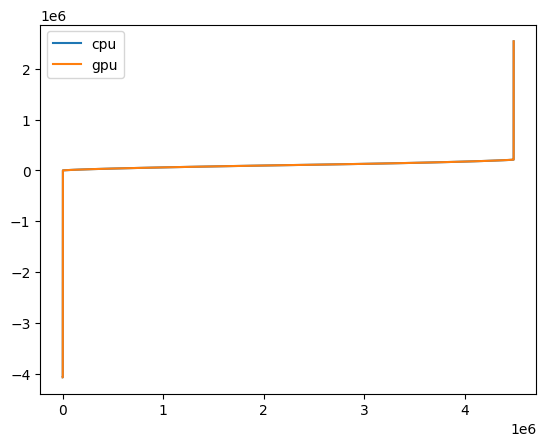

In [70]:
def verify(a, b, decimal, plot):
  if plot == True:
    plt.plot(a, label="cpu")
    plt.plot(b, label="gpu")
    plt.legend()
    plt.show()
  np.testing.assert_almost_equal(a, b, decimal=decimal, )


verify(cpu_res, gpu_res, decimal=2, plot=True)